L'objectif de cette analyse est de créer un modéle en Machine Learning et de l'entrainer avec un modéle en Deep Learning pour l'élaboration d'un modéle en IA capable de prédire si un patient est atteint de pneumonie. 

L'objectif d'apprentisage Deep Learning est de reconnaitre une radiographie d'une cage thoracique. 
Plus la radio thoracique est clair moins il a de risque de présence de pneumonie et à l'inverse plus la radio présente des zones d'opacité est plus nous devons être en mesure de prédire une pneumonie. 

Pour notre modélisation nous allons labéliser notre y, qui correspond à la variable prédite en posant : 0 pour NORMAL et 1 pour PNEUMONIE


# Import des bibliothèques
___

In [4]:
import os 
import numpy as np
import matplotlib as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import cv2

np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

2025-05-26 13:50:34.861853: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1.📚 Exploration des données 
___

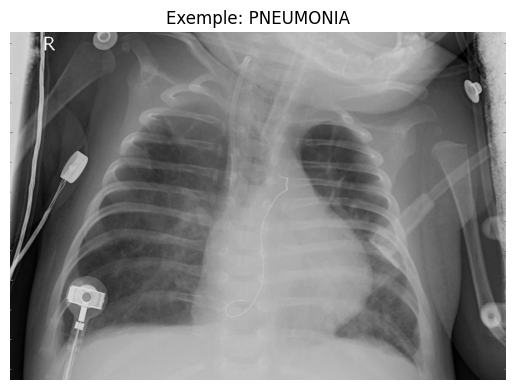

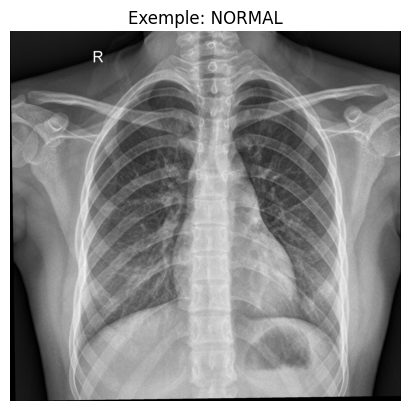


Total d'images dans 'data/chest_xray/train' : 5216

Total tailles d'images rencontrées : 4366


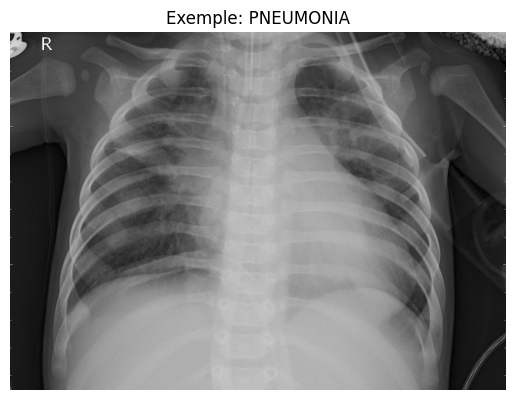

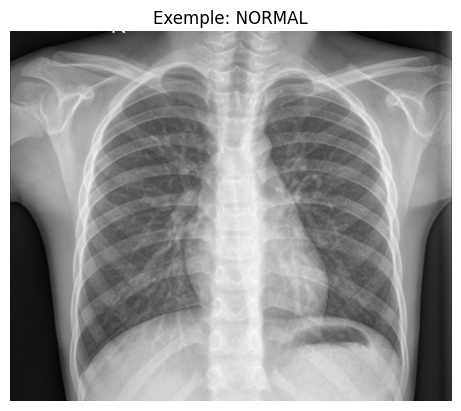


Total d'images dans 'data/chest_xray/test' : 624

Total tailles d'images rencontrées : 598


In [5]:
def explore_images(data_dir, img_read_type: int):
    """
    Explore un répertoire d'images organisé par classe (sous-dossiers).

    - Affiche la première image de chaque sous-dossier.
    - Compte le nombre total d’images.
    - Recueille les tailles uniques des images rencontrées.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant les sous-dossiers d’images.
    img_read_type : int
        Mode de lecture OpenCV (ex. cv2.IMREAD_COLOR ou cv2.IMREAD_GRAYSCALE).
    """
    
    unique_shapes = set()
    displayed = set()
    total_images = 0

    for label_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible
                unique_shapes.add(img.shape)
                total_images += 1

                # Afficher la première image de chaque dossier
                if label_name not in displayed:
                    displayed.add(label_name)
                    plt.imshow(img if img_read_type == cv2.IMREAD_GRAYSCALE else cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    plt.title(f"Exemple: {label_name}")
                    plt.axis('off')
                    plt.show()

    print(f"\nTotal d'images dans '{data_dir}' : {total_images}")
    print(f"\nTotal tailles d'images rencontrées : {len(unique_shapes)}")


explore_images("data/chest_xray/train", cv2.IMREAD_COLOR)
explore_images("data/chest_xray/test", cv2.IMREAD_COLOR)

In [6]:
# Visualisation de images au format pixels 

img_NORMAL = cv2.imread("data/chest_xray/train/NORMAL/IM-0115_0001.jpeg", cv2.IMREAD_GRAYSCALE)
img_PNEUMONIA = cv2.imread("data/chest_xray/train/PNEUMONIA/person1_bacteria_1.jpeg", cv2.IMREAD_GRAYSCALE)

print(img_NORMAL , img_PNEUMONIA)




None [[ 69  69  69  69  69  68  66  66  67  68  70  71  72  71  70  70  73  71  71  74  78  79  78  75  82  82  83  83  83  82 ... 102  99  99 101  97  89  82  85  86  83  84  90  99 104  99 106 114 119 119 118 119 120 118 120 121 120 119 118 117 118]
 [ 68  69  69  69  69  68  67  66  68  69  70  71  71  71  70  69  75  74  74  76  80  81  80  78  80  80  81  82  83  83 ... 104 101 101 102  97  89  83  85  85  83  83  88  96 102 101 107 114 117 117 116 117 119 122 123 124 123 122 121 121 121]
 [ 68  68  69  69  69  68  67  66  70  70  71  71  71  70  69  69  75  74  75  77  80  81  80  79  78  79  80  82  83  84 ... 106 103 104 104  97  88  84  84  85  83  82  85  92  99 102 107 113 114 113 113 116 118 120 120 120 121 120 119 118 118]
 [ 67  68  69  69  69  68  67  67  70  71  71  70  70  70  69  69  72  73  74  76  77  78  78  78  78  79  80  82  82  83 ... 107 105 106 105  97  88  84  84  84  84  82  82  88  95 101 105 110 111 111 113 117 121 119 119 118 119 119 119 117 116]
 [ 67  

[ WARN:0@79.341] global loadsave.cpp:268 findDecoder imread_('data/chest_xray/train/NORMAL/IM-0115_0001.jpeg'): can't open/read file: check file path/integrity


# 2.⏳ Chargement de la données 

In [7]:
def load_data(data_dir, img_read_type: int, target_size=(64, 64)):
    """
    Charge les images et les étiquettes depuis un répertoire structuré en sous-dossiers 'cat' et 'dog'.

    Parameters
    ----------
    data_dir : str
        Chemin du dossier contenant deux sous-dossiers : 'cat' et 'dog', chacun contenant les images correspondantes.
    img_read_type : int
        Mode de lecture des images pour OpenCV (par exemple cv2.IMREAD_GRAYSCALE ou cv2.IMREAD_COLOR).
    target_size : tuple (int, int), default=(64, 64)
        Dimensions finales souhaitées pour les images après redimensionnement.

    Returns
    -------
    X : 
        Tableau des images chargées et redimensionnées, converties en float32.
        La forme dépend du mode de lecture (grayscale ou couleur).
    
    y : 
        Tableau des labels (0 pour 'NORMAL', 1 pour 'PNEUMONIA').
    """

    X = []
    y = []
    label_map = {'NORMAL': 0, 'PNEUMONIA': 1}

    for label_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(data_dir, label_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible, on passe
                img = cv2.resize(img, target_size)
                X.append(img)
                y.append(label_map[label_name])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    return X, y


# Chargement des images en niveau de gris
X_train, y_train = load_data('data/chest_xray/train', cv2.IMREAD_GRAYSCALE)
X_test, y_test = load_data('data/chest_xray/test', cv2.IMREAD_GRAYSCALE)

print(X_train, y_train)
print(X_test, y_test)

[[[ 30.  28.  27.  29.  28.  29.  31.  28.  29.  28.  28.  27.  25.  26.  23.  23.  19.  19.  16.  18.  14.   3.  35. 111. 114. 118. 114. 137. 143. 174. ... 179. 159. 145. 106. 104. 120. 114. 101.  98.  77.   1.   6.  18.  19.  17.  16.  21.  23.  23.  23.  23.  25.  26.  24.  26.  27.  28.  26.  29.  26.]
  [ 29.  27.  28.  27.  29.  29.  27.  27.  25.  26.  25.  26.  25.  24.  22.  23.  17.  24.  19.  15.   0.   0.  98. 113. 131. 120. 128. 171. 174. 191. ... 154. 142. 153. 118. 108. 110. 127. 113.  88.  67.  36.  31.   7.  12.  16.  13.  18.  18.  20.  19.  20.  24.  25.  25.  26.  28.  25.  25.  28.  26.]
  [ 28.  24.  26.  27.  25.  26.  25.  23.  24.  22.  21.  21.  20.  20.  19.  13.  20.  15.   6.   8.  29.  33. 104. 132. 131. 133. 140. 153. 140. 150. ... 167. 144. 132. 116. 118. 127. 116. 114. 103.  70.  72.  43.  41.  30.   8.   5.  11.  12.  15.  19.  19.  18.  22.  24.  22.  24.  23.  26.  24.  28.]
  [ 25.  23.  26.  24.  24.  24.  26.  23.  23.  21.  20.  18.  17.  16. 255

# 2.👩🏻‍💻 Exploration des données
___

In [8]:
def explore_images(data_dir, img_read_type: int):
    
    unique_shapes = set()
    displayed = set()
    total_images = 0

    for label_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, label_name)
        if not os.path.isdir(class_dir):
            continue

        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(class_dir, filename)
                img = cv2.imread(filepath, img_read_type)
                if img is None:
                    continue  # image illisible
                unique_shapes.add(img.shape)
                total_images += 1

                # Afficher la première image de chaque dossier
                if label_name not in displayed:
                    displayed.add(label_name)
                    plt.title(f"Exemple: {label_name}")
                    plt.axis('off')
                    plt.show()

    print(f"\nTotal d'images dans '{data_dir}' : {total_images}")
    print(f"\nTotal tailles d'images rencontrées : {len(unique_shapes)}")




In [9]:

def get_images_labels(base_path: str, label_value: int, target_size=(64, 64)):
    X = []
    y = []
    valid_extensions = (".jpg", ".jpeg", ".png", ".bmp")

    for file_name in os.listdir(base_path):
        if not file_name.lower().endswith(valid_extensions):
            continue

        file_path = os.path.join(base_path, file_name)
        img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Erreur de lecture image : {file_path}")
            continue

        # Redimensionner l'image
        img_resized = cv2.resize(img, target_size)

        # Vérifier la forme et le type
        if not isinstance(img_resized, np.ndarray):
            print(f"Image non convertie en ndarray: {file_path}")
            continue
        if img_resized.shape != target_size:
            print(f"Taille inattendue: {file_path}, shape: {img_resized.shape}")
            continue

        X.append(img_resized)
        y.append(label_value)

    print(f"Images chargées dans {base_path} : {len(X)}")
    return np.array(X), np.array(y)





# 3.🧹 Préparation des données
___

In [10]:
# Appel des train/ test 

X_train_NORMAL, y_train_NORMAL = get_images_labels("data/chest_xray/train/NORMAL", 0)
X_train_PNEUMONIA, y_train_PNEUMONIA = get_images_labels("data/chest_xray/train/PNEUMONIA", 1)

X_test_NORMAL, y_test_NORMAL = get_images_labels("data/chest_xray/test/NORMAL", 0)
X_test_PNEUMONIA, y_test_PNEUMONIA = get_images_labels("data/chest_xray/test/PNEUMONIA", 1)






Images chargées dans data/chest_xray/train/NORMAL : 1341
Images chargées dans data/chest_xray/train/PNEUMONIA : 3875
Images chargées dans data/chest_xray/test/NORMAL : 234
Images chargées dans data/chest_xray/test/PNEUMONIA : 390


In [11]:
# Fusion des données d'entraînement  

X_train = np.concatenate((X_train_NORMAL, X_train_PNEUMONIA), axis=0)
y_train = np.concatenate((y_train_NORMAL, y_train_PNEUMONIA), axis=0)

print("✅ X_train shape :", X_train.shape)
print("✅ y_train shape :", y_train.shape)


✅ X_train shape : (5216, 64, 64)
✅ y_train shape : (5216,)


In [12]:
# Fusion des données de test 

X_test = np.concatenate((X_test_NORMAL, X_test_PNEUMONIA), axis=0)
y_test = np.concatenate((y_test_NORMAL, y_test_PNEUMONIA), axis=0)

print("✅ X_test shape :", X_test.shape)
print("✅ y_test shape :", y_test.shape)

✅ X_test shape : (624, 64, 64)
✅ y_test shape : (624,)


# 4.⚙️ Preprocessing
___

In [13]:
# Conversion en float32
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

# Redimensionnement des images en 150x150
def resize_images(X, size=(150, 150)):
    return np.array([cv2.resize(img, size) for img in X])

X_train = resize_images(X_train)
X_test = resize_images(X_test)

# Normalisation (pixels entre 0 et 1)
X_train /= 255.0
X_test /= 255.0

# Reshape pour ajouter la dimension des canaux (grayscale)
X_train = X_train.reshape(-1, 150, 150, 1)
X_test = X_test.reshape(-1, 150, 150, 1)



In [14]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)


# 5.🧠 Modélisation
___


# 5.1. Choix du modèle

Dans ce projet, nous avons choisi d'explorer deux approches de modélisation afin de comparer leurs performances :

 1. Modèle CNN simple (construit manuellement): 

    Nous avons d'abord conçu un réseau de neurones convolutionnel (CNN) simple avec Keras, composé de 3 à 4 couches convolutionnelles.

    ✅ Cette approche est pédagogique, intuitive, et permet de mieux comprendre les mécanismes d'apprentissage des réseaux de neurones appliqués à des images médicales.

 2. Transfer learning (modèle pré-entraîné): 

    Nous avons ensuite utilisé un modèle pré-entraîné (par exemple MobileNetV2 ou ResNet50) via la technique du transfer learning.

    ✅ Ce type de modèle a été préalablement entraîné sur une grande base de données (ImageNet), et permet de réutiliser des représentations déjà efficaces pour notre tâche.



🎯 Objectif de la double approche : 

Permettre d’améliorer la précision du modèle, en particulier lorsque le jeu de données est limité.
La double expérimentation permet d'observer les différences de performance, de vitesse d'apprentissage, et de généralisation entre un modèle entraîné de zéro et un modèle transféré.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 1)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # sortie binaire
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,827,905 (18.42 MB)

 Trainable params: 4,827,905 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

# 5.2. Entrainement du modéle 

In [2]:
from sklearn.utils import class_weight


class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))






NameError: name 'np' is not defined

In [1]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    class_weight=class_weights)

NameError: name 'model' is not defined

# 6. 📊 Évaluation du modèle
_____

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"🔍 Test accuracy: {accuracy:.2f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.6141 - loss: 0.7071
🔍 Test accuracy: 0.62


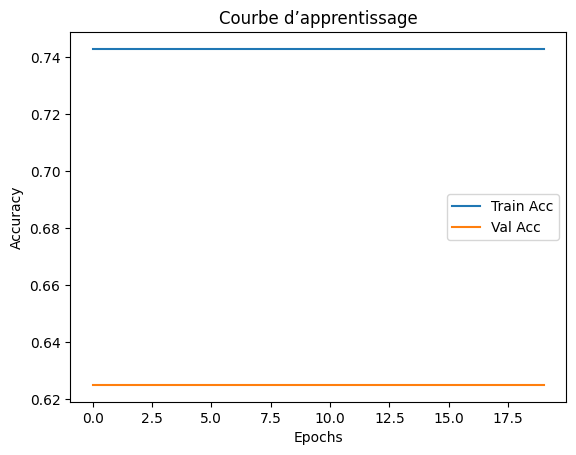

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Courbe d’apprentissage")
plt.legend()
plt.show()


#  🔁 7. Matrice de confusion 
____

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 236ms/step


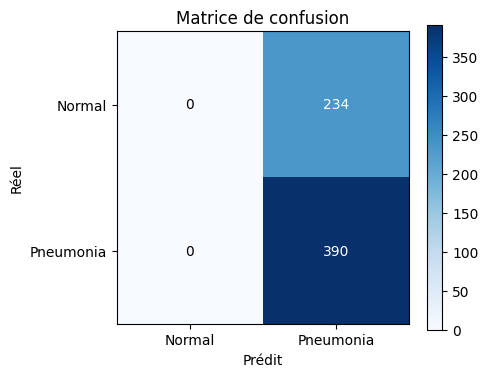

In [ ]:
from sklearn.metrics import confusion_matrix

# 1. Prédictions binaires
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# 2. Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# 3. Affichage avec matplotlib
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Matrice de confusion")
plt.colorbar()

classes = ["Normal", "Pneumonia"]
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# 4. Afficher les valeurs dans la matrice
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center", color="white" if cm[i, j] > cm.max()/2. else "black")

plt.ylabel("Réel")
plt.xlabel("Prédit")
plt.tight_layout()
plt.show()


In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([1341, 3875]))